## Описание проекта

Интернет-магазин Apparel собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель:**
Предсказать вероятность покупки в течение 90 дней.


**Задачи:**
* Изучить данные
* Разработать полезные признаки
* Создать модель для классификации пользователей
* Улучшить модель и максимизировать метрику roc_auc
* Выполнить тестирование

### Описание данных

Интернет-магазин Apparel предоставил наборы исторических данных и взаоимодействии с пользователями.

**Данные покупках клиентов по дням и по товарам: `apparel-purchases.csv`.**

В каждой записи покупка определенного товара, его цена, количество штук.

- `client_id` — идентификатор клиента;
- `quantity` — количество единиц товара;
- `price` — цена товара;
- `category_ids` — идентификаторы категорий;
- `date` — дата покупки;
- `message_id` — идентификатор сообщения из рассылки.

В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например: автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам.

Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594'].

**Данные о рассылках клиентам: `apparel-messages.csv`.**

Рассылки, которые были отправлены клиентам из таблицы покупок.

- `bulk_campaign_id` — идентификатор рассылки;
- `client_id` — идентификатор клиента;
- `message_id` — идентификатор сообщения;
- `event` — действие с сообщением (отправлено, открыто, покупка…);
- `channel` — канал рассылки;
- `date` — дата действия;
- `created_at` — дата-время полностью;

**Целевой признак: `apparel-target_binary.csv`.**

Бинарный признак - совершил ли клиент покупку в течение следующих 90 дней после взаимодействия.

- `client_id` — идентификатор клиента;
- `target` — клиент совершил покупку в целевом периоде.

**Данные о рассылках по дням: `full_campaign_daily_event.csv`.**

Агрегация общей базы рассылок по дням и типам событий. В именах колонок указаны типы событий event

- `date` — дата;
- `bulk_campaign_id` — идентификатор рассылки;
- `count_event` — общее количество каждого события event;
- `nunique_event` — количество уникальных client_id в каждом событии.

**Данные о рассылках по каналам: `full_campaign_daily_event_channel.csv`.**

Агрегация по дням с учетом событий и каналов рассылки. В именах колонок указаны все типы событий event и каналы рассылки channel

- `date` — дата;
- `bulk_campaign_id` — идентификатор рассылки;
- `count_event` — общее количество каждого события по каналам;
- `nunique_event` — количество уникальных client_id по событиям и каналам.

## Загрузка данных

In [1]:
# Установка библиотек
!pip install catboost -q

In [2]:
import ast
import gc
import warnings
warnings.filterwarnings('ignore')

import requests
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, roc_auc_score, roc_curve, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler


In [3]:
# Настройка отображения всех столбцов
pd.set_option('display.max_columns', None)

In [4]:
# Определение переменных
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Файлы были предварительно загружены в облачное хранилище Object Storage в Yandex Cloud.

In [5]:
%%time

# Загружаем датасеты на диск во временную папку
datasets = {
    "purchases": "https://storage.yandexcloud.net/ds-datasets-1/apparel-purchases.csv",
    "messages": "https://storage.yandexcloud.net/ds-datasets-1/apparel-messages.csv",
    "events": "https://storage.yandexcloud.net/ds-datasets-1/full_campaign_daily_event.csv",
    "events_channel": "https://storage.yandexcloud.net/ds-datasets-1/full_campaign_daily_event_channel.csv",
    "target": "https://storage.yandexcloud.net/ds-datasets-1/apparel-target_binary.csv"
}

def download_file(name, url):
    """Скачивает файл с прогрессом и проверкой"""
    filename = url.split('/')[-1]
    filepath = f'/tmp/{filename}'

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(filepath, 'wb') as f:
        with tqdm(total=total_size, unit='B', unit_scale=True, desc=name) as pbar:
            for chunk in response.iter_content(chunk_size=1024*1024):
                f.write(chunk)
                pbar.update(len(chunk))

# Загружаем все датасеты
for name, url in datasets.items():
    download_file(name, url)

purchases:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

messages:   0%|          | 0.00/1.41G [00:00<?, ?B/s]

events:   0%|          | 0.00/8.19M [00:00<?, ?B/s]

events_channel:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

target:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

CPU times: user 6.77 s, sys: 6.17 s, total: 12.9 s
Wall time: 2min 7s


In [6]:
%%time

# Загружаем датасеты в pandas
purchases = pd.read_csv('/tmp/apparel-purchases.csv')
messages = pd.read_csv('/tmp/apparel-messages.csv')
events = pd.read_csv('/tmp/full_campaign_daily_event.csv')
events_channel = pd.read_csv('/tmp/full_campaign_daily_event_channel.csv')
target = pd.read_csv('/tmp/apparel-target_binary.csv')

CPU times: user 24.2 s, sys: 5.62 s, total: 29.8 s
Wall time: 30 s


### Проверка результатов загрузки

In [7]:
# Проверяем результат загрузки
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [8]:
# Выведем информацию о датасете
purchases.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.4 MB


Так как датасеты большого объема, с целью экономии оперативной памяти, преобразуем типы данных к более компактному виду.

In [9]:
# Посмотрим перед преобзованием максимальное значение для определения типа данных
purchases['quantity'].max()

30

Для таких максимальных значений будет достаточно типа `int16`.

In [10]:
# Преобразуем типы данных для экономии памяти
print(f"До: {purchases.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

purchases['quantity'] = purchases['quantity'].astype('int16')
purchases['date'] = pd.to_datetime(purchases['date'])

# Освобождаем память от старых объектов
gc.collect()

# Проверим результат после
print(f"После: {purchases.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

До: 47.4 MB
После: 36.4 MB


In [11]:
# Проверим диапазон дат
min_date_purchases = purchases['date'].min()
max_date_purchases = purchases['date'].max()
print('Минимальное значение даты в date:', min_date_purchases)
print('Максимальное значение даты в date:', max_date_purchases)

Минимальное значение даты в date: 2022-05-16 00:00:00
Максимальное значение даты в date: 2024-02-16 00:00:00


**Краткий вывод по датасету `purchases`:**

* Названия столбцов представлены в виде snake_case
* В датасете содержится 202208 строк, явных пропусков в данных нет
* Объем памяти занимаемой датасетом сокращен с 47.4 MB до 36.4 MB
* Данные о покупках представлены за 1 год и 9 месяцев: с 2022-05-16 по 2024-02-16

---

In [12]:
# Проверяем результат загрузки
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [13]:
# Выведем информацию о датасете
messages.info(memory_usage='deep', show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Non-Null Count     Dtype 
---  ------            --------------     ----- 
 0   bulk_campaign_id  12739798 non-null  int64 
 1   client_id         12739798 non-null  int64 
 2   message_id        12739798 non-null  object
 3   event             12739798 non-null  object
 4   channel           12739798 non-null  object
 5   date              12739798 non-null  object
 6   created_at        12739798 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.0 GB


In [14]:
# Посмотрим перед преобзованием максимальное значение для определения типа данных
messages['bulk_campaign_id'].max()

14657

Для таких максимальных значений будет достаточно типа `int16`.

In [15]:
# Преобразуем типы данных для экономии памяти
print(f"До: {messages.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

messages['bulk_campaign_id'] = messages['bulk_campaign_id'].astype('int16')
messages['created_at'] = pd.to_datetime(messages['created_at'])
messages['date'] = pd.to_datetime(messages['date'])

# Освобождаем память от старых объектов
gc.collect()

# Проверим результат после
print(f"После: {messages.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

До: 4146.7 MB
После: 2725.2 MB


In [16]:
# Проверим диапазон дат
min_date_messages = messages['date'].min()
max_date_messages = messages['date'].max()
print('Минимальное значение даты в date:', min_date_messages)
print('Максимальное значение даты в date:', max_date_messages)

Минимальное значение даты в date: 2022-05-19 00:00:00
Максимальное значение даты в date: 2024-02-15 00:00:00


In [17]:
# Проверим диапазон дат создания записей
min_date_messages_created = messages['created_at'].min()
max_date_messages_created = messages['created_at'].max()
print('Минимальное значение даты в created_at:', min_date_messages_created)
print('Максимальное значение даты в created_at:', max_date_messages_created)

Минимальное значение даты в created_at: 2022-05-19 00:14:20
Максимальное значение даты в created_at: 2024-02-15 23:58:40


**Краткий вывод по датасету `messages`:**

* Названия столбцов представлены в виде snake_case
* В датасете содержится 12739798 строк, явных пропусков в данных нет
* Столбец `message_id` состоит из трех частей: `client_id` + `bulk_campaign_id` + <id сообщения>
* Объем памяти занимаемой датасетом сокращен с 4.0 GB до 2.7 GB, за счет преобразования типов данных
* Данные о рассылках представлены за 1 год и 9 месяцев: с 2022-05-19 по 2024-02-15
* В датасете о покупках самая ранняя дата покупки 2022-05-16, а самая ранняя дата о рассылках на 3 дня позже этой даты 2022-05-19. Таким образом, в предыдещем датасете `purchases` есть покупки, которые были совершены до рассылки.

---

In [18]:
messages.query('bulk_campaign_id == 15143')

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at


In [19]:
# Проверяем результат загрузки
events.sort_values(by=['bulk_campaign_id', 'date']).tail(50)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
130531,2024-05-12,15132,2069,0,0,4943,5,0,0,0,0,1648,0,0,4920,5,0,0,0,0,0,0,0,0
130762,2024-05-13,15132,682,0,0,1258,4,0,0,0,0,561,0,0,1252,4,0,0,0,0,0,0,0,0
130997,2024-05-14,15132,192,0,0,19,3,0,0,0,0,179,0,0,19,3,0,0,0,0,0,0,0,0
130532,2024-05-12,15133,15040,0,4671,445894,41,773982,538,0,0,14359,0,4429,440129,35,773982,538,0,0,0,0,0,0
130763,2024-05-13,15133,4457,0,490,50580,43,92476,68,0,0,4033,0,466,49838,41,92476,68,0,0,0,0,0,0
130998,2024-05-14,15133,1288,0,0,771,24,0,0,0,0,1052,0,0,764,20,0,0,0,0,0,0,0,0
129557,2024-05-08,15134,20,0,0,42,0,57,0,0,0,16,0,0,38,0,57,0,0,0,0,0,0,0
129799,2024-05-09,15134,7,0,0,1,0,0,0,0,0,6,0,0,1,0,0,0,0,0,0,0,0,0
130055,2024-05-10,15134,5,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0
130296,2024-05-11,15134,4,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
# Выведем информацию о датасете
events.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

In [21]:
# Преобразуем типы данных для экономии памяти
print(f"До: {events.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

events['date'] = pd.to_datetime(events['date'])

# Освобождаем память от старых объектов
gc.collect()

# Проверим результат после
print(f"После: {events.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

До: 30.4 MB
После: 24.0 MB


In [22]:
# Проверим диапазон дат
min_date_events = events['date'].min()
max_date_events = events['date'].max()
print('Минимальное значение даты в date:', min_date_events)
print('Максимальное значение даты в date:', max_date_events)

Минимальное значение даты в date: 2022-05-19 00:00:00
Максимальное значение даты в date: 2024-05-15 00:00:00


**Краткий вывод по датасету `events`:**

* Названия столбцов представлены в виде snake_case
* В датасете содержится 131072 строк, явных пропусков в данных нет
* Объем памяти занимаемой датасетом сокращен с 30.4 MB до 24.0 MB, за счет преобразования типов данных
* Данные о рассылках представлены за 1 год и 9 месяцев: с 2022-05-19 по 2024-02-15

---

In [23]:
# Проверяем результат загрузки
events_channel.head()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# Выведем информацию о датасете
events_channel.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

In [25]:
# Преобразуем типы данных для экономии памяти
print(f"До: {events_channel.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

events_channel['date'] = pd.to_datetime(events_channel['date'])

# Освобождаем память от старых объектов
gc.collect()

# Проверим результат после
print(f"После: {events_channel.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

До: 42.4 MB
После: 36.0 MB


In [26]:
# Проверим диапазон дат
min_date_events_channel = events_channel['date'].min()
max_date_events_channel = events_channel['date'].max()
print('Минимальное значение даты в date:', min_date_events_channel)
print('Максимальное значение даты в date:', max_date_events_channel)

Минимальное значение даты в date: 2022-05-19 00:00:00
Максимальное значение даты в date: 2024-05-15 00:00:00


**Краткий вывод по датасету `events_channel`:**

* Названия столбцов представлены в виде snake_case
* В датасете содержится 131072 строк, явных пропусков в данных нет. Количество строк соответствует количеству строк в предыдущем датасете `events`
* Объем памяти занимаемой датасетом сокращен с 42.4 MB до 36.0 MB, за счет преобразования типов данных
* Данные о рассылках представлены за 1 год и 9 месяцев: с 2022-05-19 по 2024-02-15



---



In [27]:
# Проверяем результат загрузки
target.head(3)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0


In [28]:
# Выведем информацию о датасете
target.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


**Краткий вывод по датасету с целевым признаком `target`:**

* Названия столбцов представлены в виде snake_case
* В датасете содержится 49849 строк, явных пропусков в данных нет
* Объем памяти занимаемой датасетом всего 779.0 KB, поэтому преобразований не выполнялось
* Значения представлены целочисленным типом данных "0" и "1"

## Предобработка данных

### Поиск дубликатов

Проверим наличие явных дубликатов во всех датасетах.

In [29]:
# Проверим наличие дубликатов
print('Количество строк-дубликатов в purchases:', purchases.duplicated().sum())

Количество строк-дубликатов в purchases: 73020


В большинстве случаев количество товаров в заказе равно единице, очевидно, что каждый дубликат - это второй (и последующий) товар в одном заказе, а не аномалия. Поэтому эти дубликаты удалять не будем.

In [30]:
# Проверим наличие дубликатов
print('Количество строк-дубликатов в messages:', messages.duplicated().sum())

Количество строк-дубликатов в messages: 48610


Здесь дубликаты это аномалии, т.к. повторяются значения во всех ячейках, включая точное время (до секунды) создания сообщения. Удалим эти дубликаты.

In [31]:
# Удаляем дубликаты в messages
messages.drop_duplicates(inplace=True)

In [32]:
# Проверим наличие дубликатов после обработки
print('Количество строк-дубликатов в messages после обработки:', messages.duplicated().sum())

Количество строк-дубликатов в messages после обработки: 0


In [33]:
# Проверим наличие дубликатов
print('Количество строк-дубликатов в events:', events.duplicated().sum())

Количество строк-дубликатов в events: 0


In [34]:
# Проверим наличие дубликатов
print('Количество строк-дубликатов в events_channel:', events_channel.duplicated().sum())

Количество строк-дубликатов в events_channel: 0


In [35]:
# Проверим наличие дубликатов
print('Количество строк-дубликатов в target:', target.duplicated().sum())

Количество строк-дубликатов в target: 0


**Краткий вывод по дубликатам:**

В датасете `messages` было выявлено 48610 строк-дубликатов. Эти дубликаты были удалены.



---



Теперь проверим наличие скрытых дубликатов в категориальных признаках. Категориальные признаки (`event`, `channel`) есть только в датасете `messages`. Проверим все уникальные значения категориальных признаков.

In [36]:
# Проверяем уникальные значения в event
messages.event.unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [37]:
# Проверяем уникальные значения в channel
messages.channel.unique()

array(['email', 'mobile_push'], dtype=object)

**Краткий вывод по скрытым дубликатам:**

Скрытых дубликатов в данных не обнаружено. Поиск аномальных значений будем выполнять в процессе исследовательского анализа данных.

## Исследовательский анализ данных

Перед проведением исследовательского анализа выведем все виды каналов взаимодействия и типы событий.

Получим список всех каналов из датасета `messages`.

In [38]:
# Выводим список каналов
sorted(list(messages.channel.unique()))

['email', 'mobile_push']

**Описание каналов:**

* `email` - рассылка по электронной почте.
* `mobile_push` - рассылка в клиентском приложении.

Получим список всех событий из датасета `messages`.

In [39]:
# Выводим список событий
sorted(list(messages.event.unique()))

['click',
 'close',
 'complain',
 'hard_bounce',
 'hbq_spam',
 'open',
 'purchase',
 'send',
 'soft_bounce',
 'subscribe',
 'unsubscribe']

**Описание типов событий:**

| Этап воронки | Событие | Перевод | Описание |
| :--- | :--- | :--- | :--- |
| **1. Отправка** | **send** | Отправка | Сообщение успешно передано почтовому серверу. |
| **1. Отправка** | **soft_bounce** | Мягкий возврат | Временная задержка (ящик полон, сервер занят). |
| **1. Отправка** | **hard_bounce** | Жесткий возврат | Критическая ошибка (адреса не существует). |
| **1. Отправка** | **hbq_spam** | Блокировка (спам) | Сообщение отсечено фильтрами до получения. |
| **2. Доставка** | **open** | Открытие | Факт просмотра (загрузки пикселя) сообщения. |
| **3. Реакция** | **click** | Клик | Переход по ссылке внутри письма или уведомления. |
| **3. Реакция** | **close** | Закрытие | Пользователь закрыл уведомление или окно сообщения (без клика). |
| **4. Отток** | **unsubscribe** | Отписка | Отказ пользователя от получения уведомлений. |
| **4. Отток** | **complain** | Жалоба на спам | Пользователь отметил письмо как нежелательное. |
| **5. Покупка** | **purchase** | Покупка | Совершение покупки после перехода из сообщения. |
| **-** | **subscribe** | Подписка | Регистрация пользователя в базе рассылки. |



---



Выведем основные описательные статистики в датасетах `purchases`, `events`, `events_channel`. Заодно проверим наличие аномальных значений.

In [40]:
# Выводим описательные статистики в purchases
purchases.drop(['client_id', 'date'], axis=1).describe()

,quantity,price
count,202208.000000,202208.000000
mean,1.006483,1193.301516
std,0.184384,1342.252664
min,1.000000,1.000000
25%,1.000000,352.000000
50%,1.000000,987.000000
75%,1.000000,1699.000000
max,30.000000,85499.000000


* Большинство покупок в заказе по 1 штуке
* Есть покупки стоиомостью 1 ₽. Это либо акционная покупка, либо аномалия.
* Максимальная стомость покупки 85_499 ₽.

In [41]:
# Выводим описательные статистики в events
events.drop(['date', 'bulk_campaign_id'], axis=1).describe()

,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,6.362679,74.276016,0.921326,77.398689,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
std,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,79.172069,1004.271405,29.715170,1913.395511,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,9089.000000,75899.000000,5043.000000,287341.000000,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000


* По большей части состоит из нулей.
* Есть рассылки в которых большое количество рассылок и высокая активность.
* Возможно слишком большие значения это строка итогов. Требует проверки.

In [42]:
# Выводим описательные статистики в events_channel
events_channel.drop(['date', 'bulk_campaign_id'], axis=1).describe()

,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,6.362679,31.396263,42.879753,4.116615e+02,3.271339e+03,0.287712,0.177391,24.262146,0.134125,5.960602,59.483444,7.444562e+03,58.863007,7.350267e+03,18.989990,0.810364,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
std,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,79.172069,562.883309,833.316257,9.519713e+03,6.188001e+04,6.484979,2.971908,724.270910,1.976439,73.284148,1371.955350,1.393509e+05,1357.271261,1.355799e+05,1402.414107,183.298579,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762
min,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,9089.000000,45718.000000,75899.000000,2.548617e+06,2.922440e+06,779.000000,359.000000,76281.000000,177.000000,8299.000000,165526.000000,1.154351e+07,165526.000000,6.636578e+06,287404.000000,63920.000000,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000


* По большей части состоит из нулей.
* Есть рассылки в которых большое количество рассылок и высокая активность.
* Возможно слишком большие значения это строка итогов. Требует проверки.


---



Посчитаем количество уникальных клиентов, которые совершали покупки (датасет `purchases`) и количество уникальных клиентов, которым были разосланы промо-сообщения (датасет `messages`).

In [43]:
# Считаем кол-во уникальных клиентов, которые совершали покупки
print(f"Кол-во клиентов, которые совершили хотя бы одну покупку: {len(purchases.client_id.unique())}")

Кол-во клиентов, которые совершили хотя бы одну покупку: 49849


In [44]:
# Считаем кол-во уникальных клиентов, которым были разосланы сообщения
print(f"Кол-во клиентов, которым разослали промо-сообщения: {len(messages.client_id.unique())}")

Кол-во клиентов, которым разослали промо-сообщения: 53329


Количество клиентов, которые совершили покупки, и которым разослали сообщения отличается. Клиентов, которые совершили покупки, немного меньше, и это ожидаемо. Количество клиентов, которые совершили покупки соответствует количеству уникальных записей в таблице с целевым признаком `target` - 49849.

Теперь сравним количество уникальных сообщений в датасетах `purchases` и `messages`.

In [45]:
# Считаем кол-во уникальных сообщений в messages
n_mes_sent = len(messages.message_id.unique())
print("Количество уникальных сообщений в 'messages':", n_mes_sent)

Количество уникальных сообщений в 'messages': 9061667


In [46]:
# Считаем кол-во уникальных сообщений в purchases
n_mes_purch = len(purchases.message_id.unique())
print("Количество уникальных сообщений в 'purchases':", n_mes_purch)

Количество уникальных сообщений в 'purchases': 50204


Количество всех уникальных разосланных сообщений значительно больше, чем сообщений, по которым была совершена покупка. И это нормально. Посчитаем общую конверсию из рассылки в покупку.

In [47]:
# Считаем конверсию
print(f"Общая конверсия из рассылки в покупку: {((n_mes_purch / n_mes_sent) * 100):.2f}%")

Общая конверсия из рассылки в покупку: 0.55%


В целом,  такая конверсия из раасылки в покупку считается неплохой.

---

Посмотрим распределения числовых признаков из покупок.

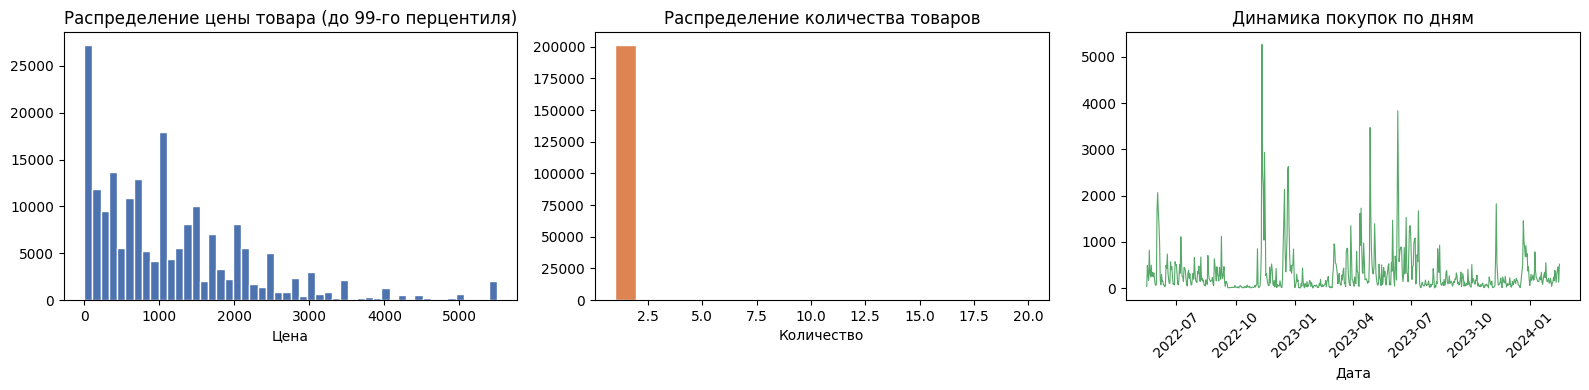

In [48]:
# Строим графики распределения числовых признаков из покупок
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Распределение price
axes[0].hist(purchases['price'].dropna().clip(upper=purchases['price'].quantile(0.99)),
             bins=50, color='#4C72B0', edgecolor='white')
axes[0].set_title('Распределение цены товара (до 99-го перцентиля)')
axes[0].set_xlabel('Цена')

# Распределение quantity
axes[1].hist(purchases['quantity'].dropna().clip(upper=20),
             bins=20, color='#DD8452', edgecolor='white')
axes[1].set_title('Распределение количества товаров')
axes[1].set_xlabel('Количество')

# Динамика покупок по дням
purchases_daily = purchases.groupby(purchases['date'].dt.date).size()
axes[2].plot(purchases_daily.index, purchases_daily.values, color='#55A868', linewidth=0.8)
axes[2].set_title('Динамика покупок по дням')
axes[2].set_xlabel('Дата')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

* Большая часть товаров имеет цену не более 3000 ₽.
* В большинстве случаев в каждом заказе не более одного товара.
* На графике динамики покупок по дням прослеживается сезонность.


---

После загрузки файла .csv в датафрейм `purchases` столбец `category_ids` был распакован как текст, а не список. Перед анализом категорий преобразуем значения в этом столбце из текста в список.

In [49]:
# Преобразуем значения в столбце из текста в список
purchases['category_ids'] = purchases['category_ids'].apply(ast.literal_eval)

В описании данных указано, что порядок категорий может меняться, поэтому правильнее будет посчитать количество уникальных категорий игнорируя порядок их расположения. Для этого преобразуем списки категорий во frozenset (неупорядоченное неизменяемое множество), что позволяет игнорировать порядок категорий и посчитать количество уникальных наборов категорий.

In [50]:
# Считаем кол-во уникальных категорий в purchases
len(set(purchases['category_ids'].apply(frozenset)))

933

Посмотрим как распределено количество категорий в каждой покупке.

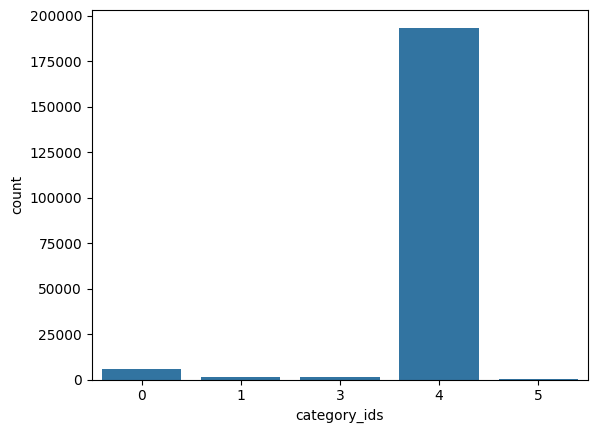

In [51]:
# Извлекаем данные о количестве категорий в список
cat_counts_list = purchases['category_ids'].apply(len)
sns.countplot(x=cat_counts_list)
plt.show()

Посмотрим какие категории встречаются чаще всего.

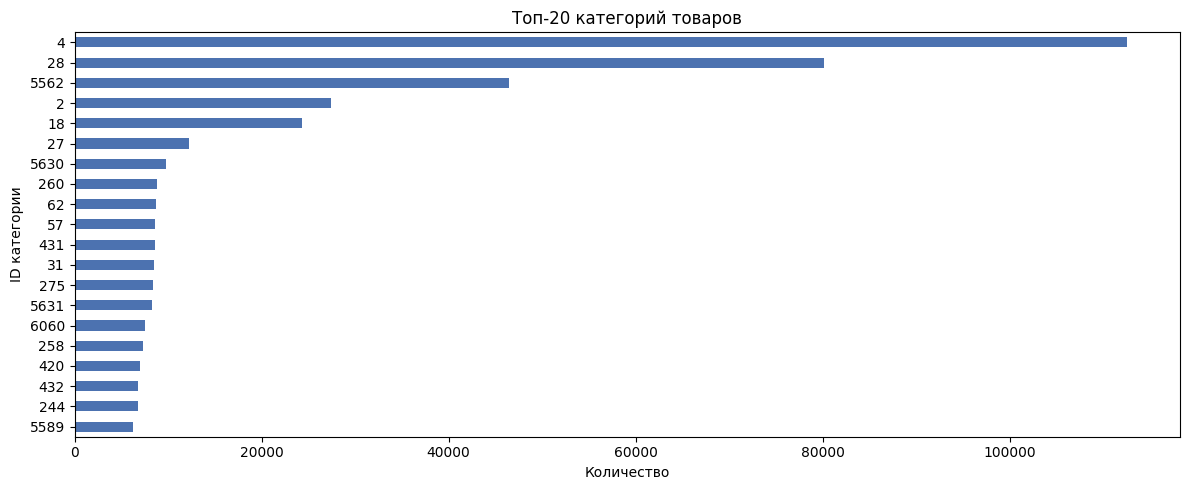

In [52]:
# Извлекаем все категории и считаем частоты
all_cats = purchases['category_ids'].explode().dropna()
all_cats = all_cats[all_cats != '']  # убираем пустые строки
top_cats = all_cats.value_counts().head(20)

fig, ax = plt.subplots(figsize=(12, 5))
top_cats.plot(kind='barh', ax=ax, color='#4C72B0')
ax.set_title('Топ-20 категорий товаров')
ax.set_xlabel('Количество')
ax.set_ylabel('ID категории')
ax.invert_yaxis()
plt.tight_layout()
plt.show()



---



Теперь посмотрим как распределены события в маркетинговых рассылках.

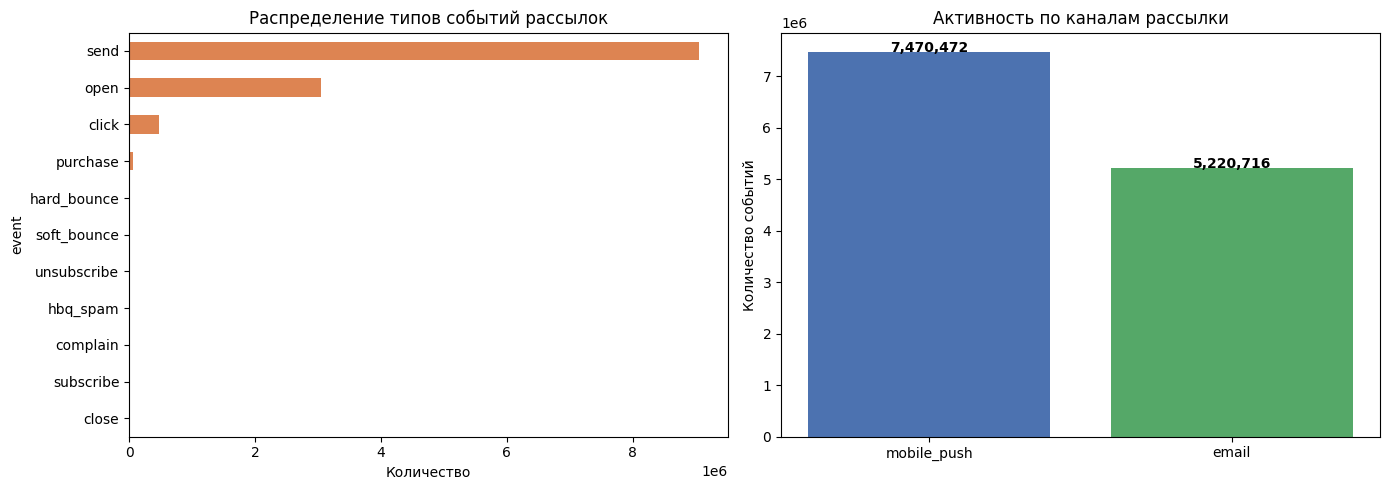

In [53]:
# Строим графики событий в рассылках
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Распределение событий
event_counts = messages['event'].value_counts()
event_counts.plot(kind='barh', ax=axes[0], color='#DD8452')
axes[0].set_title('Распределение типов событий рассылок')
axes[0].set_xlabel('Количество')
axes[0].invert_yaxis()

# Активность по каналам
channel_counts = messages['channel'].value_counts()
axes[1].bar(channel_counts.index, channel_counts.values, color=['#4C72B0', '#55A868'])
axes[1].set_title('Активность по каналам рассылки')
axes[1].set_ylabel('Количество событий')
for i, v in enumerate(channel_counts.values):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

* На графике распределения событий видна классическая "воронка".
* Расслок push уведомлений больше, чем рассылок писем (в соотношении примерно 60/40)


---



Посмотрим на распределение целевой переменной.

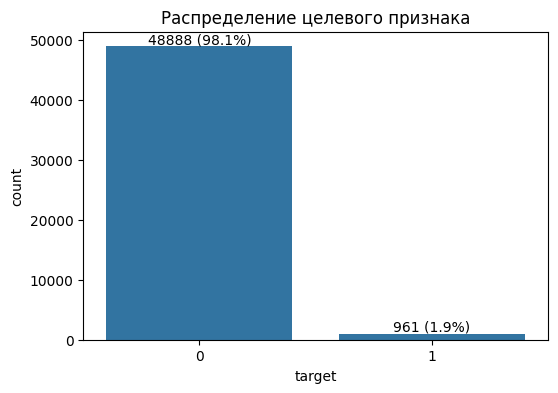

In [54]:
# Строим график распределения таргета
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='target', data=target)
total = len(target)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    # Выводим подписи значений
    ax.annotate(f'{count} ({percentage})', (x, y), ha='center', va='bottom')

plt.title('Распределение целевого признака')
plt.show()

## Генерация признаков (Feature Engineering)

In [55]:
# Определяем максимальную дату для расчёта давности (от которой будет отсчет давности)
ref_date_purchases = purchases['date'].max()
ref_date_messages = messages['date'].max()
ref_date = max(ref_date_purchases, ref_date_messages)
print(f'Референсная дата: {ref_date}')

Референсная дата: 2024-02-16 00:00:00


### Признаки из покупок

Создадим новые признаки из `purchases`

In [56]:
# Сумма каждой строки покупки
purchases['total_spend'] = purchases['price'] * purchases['quantity']

# Создание агрегированных признаков по client_id
purch_agg = purchases.groupby('client_id').agg(
    purch_count=('price', 'size'),                 # общее количество покупок
    purch_total_spend=('total_spend', 'sum'),      # общая сумма
    purch_avg_spend=('total_spend', 'mean'),       # средний чек
    purch_median_spend=('total_spend', 'median'),  # медианный чек
    purch_max_spend=('total_spend', 'max'),        # максимальный чек
    purch_min_price=('price', 'min'),              # минимальная цена
    purch_max_price=('price', 'max'),              # максимальная цена
    purch_avg_qty=('quantity', 'mean'),            # среднее количество в заказе
    purch_total_qty=('quantity', 'sum'),           # общее количество товаров
    purch_last_date=('date', 'max'),               # дата последней покупки
    purch_first_date=('date', 'min'),              # дата первой покупки
    purch_std_spend=('total_spend', 'std'),        # вариация трат
).reset_index()

# Давность последней покупки (в днях)
purch_agg['purch_recency'] = (ref_date - purch_agg['purch_last_date']).dt.days

# Период клиентской активности (в днях)
purch_agg['purch_tenure'] = (purch_agg['purch_last_date'] - purch_agg['purch_first_date']).dt.days

# Частота покупок (покупок в день активности)
purch_agg['purch_frequency'] = purch_agg['purch_count'] / (purch_agg['purch_tenure'] + 1)

# Удаляем вспомогательные столбцы с датами
purch_agg.drop(columns=['purch_last_date', 'purch_first_date'], inplace=True)

# Заполняем NaN в std (когда 1 покупка)
purch_agg['purch_std_spend'] = purch_agg['purch_std_spend'].fillna(0)

print(f'Признаки из покупок: {purch_agg.shape}')
purch_agg.head(3)

Признаки из покупок: (49849, 14)


,client_id,purch_count,purch_total_spend,purch_avg_spend,purch_median_spend,purch_max_spend,purch_min_price,purch_max_price,purch_avg_qty,purch_total_qty,purch_std_spend,purch_recency,purch_tenure,purch_frequency
0,1515915625468060902,7,6993.0,999.000000,999.0,1999.0,199.0,1999.0,1.0,7,802.080628,630,0,7.0
1,1515915625468061003,7,16235.0,2319.285714,2100.0,3499.0,1749.0,3499.0,1.0,7,560.494042,408,0,7.0
2,1515915625468061099,1,299.0,299.000000,299.0,299.0,299.0,299.0,1.0,1,0.000000,640,0,1.0


Создадим признаки из категорий товаров

In [57]:
# Количество уникальных категорий на клиента
cat_unique = purchases.explode('category_ids').groupby('client_id')['category_ids'].nunique().reset_index()
cat_unique.columns = ['client_id', 'purch_n_unique_cats']

# Количество уровней вложенности (длина списка категорий — косвенный признак)
purchases['cat_depth'] = purchases['category_ids'].apply(len)
cat_depth_agg = purchases.groupby('client_id')['cat_depth'].agg(['mean', 'max']).reset_index()
cat_depth_agg.columns = ['client_id', 'purch_avg_cat_depth', 'purch_max_cat_depth']

# Определяем топ-5 категорий верхнего уровня и создаём бинарные признаки
purchases['top_cat'] = purchases['category_ids'].apply(
    lambda x: str(x[0]) if len(x) > 0 else 'unknown'
)
top5_global = purchases['top_cat'].value_counts().head(5).index.tolist()

for cat_val in top5_global:
    col_name = f'purch_has_topcat_{cat_val}'
    tmp = purchases[purchases['top_cat'] == cat_val].groupby('client_id').size().reset_index(name=col_name)
    cat_unique = cat_unique.merge(tmp, on='client_id', how='left')
    cat_unique[col_name] = cat_unique[col_name].fillna(0).astype(int)

# Объединяем признаки категорий
cat_features = cat_unique.merge(cat_depth_agg, on='client_id', how='left')

print(f'Признаки из категорий: {cat_features.shape}')
cat_features.head(3)

Признаки из категорий: (49849, 9)


,client_id,purch_n_unique_cats,purch_has_topcat_4,purch_has_topcat_5562,purch_has_topcat_2,purch_has_topcat_6060,purch_has_topcat_unknown,purch_avg_cat_depth,purch_max_cat_depth
0,1515915625468060902,13,7,0,0,0,0,4.0,4
1,1515915625468061003,4,7,0,0,0,0,4.0,4
2,1515915625468061099,4,1,0,0,0,0,4.0,4


### Признаки из рассылок

Создадним признаки из `messages`.

In [58]:
# Количество событий каждого типа на клиента
event_pivot = messages.groupby(['client_id', 'event']).size().unstack(fill_value=0).reset_index()
event_pivot.columns = ['client_id'] + [f'msg_{col}' for col in event_pivot.columns[1:]]

# Количество уникальных кампаний
n_campaigns = messages.groupby('client_id')['bulk_campaign_id'].nunique().reset_index()
n_campaigns.columns = ['client_id', 'msg_n_campaigns']

# Активность по каналам
channel_pivot = messages.groupby(['client_id', 'channel']).size().unstack(fill_value=0).reset_index()
channel_pivot.columns = ['client_id'] + [f'msg_channel_{col}' for col in channel_pivot.columns[1:]]

# Доля email среди всех событий клиента
email_col = 'msg_channel_email' if 'msg_channel_email' in channel_pivot.columns else None
push_col = 'msg_channel_mobile_push' if 'msg_channel_mobile_push' in channel_pivot.columns else None

if email_col and push_col:
    total_ch = channel_pivot[email_col] + channel_pivot[push_col]
    channel_pivot['msg_email_ratio'] = (channel_pivot[email_col] / total_ch.replace(0, np.nan)).fillna(0)

# Конверсии
msg_features = event_pivot.merge(n_campaigns, on='client_id', how='left')
msg_features = msg_features.merge(channel_pivot, on='client_id', how='left')

# CTR
if 'msg_open' in msg_features.columns and 'msg_click' in msg_features.columns:
    msg_features['msg_ctr'] = (msg_features['msg_click'] / msg_features['msg_open'].replace(0, np.nan)).fillna(0)

# purchase / click
if 'msg_purchase' in msg_features.columns and 'msg_click' in msg_features.columns:
    msg_features['msg_purch_per_click'] = (
        msg_features['msg_purchase'] / msg_features['msg_click'].replace(0, np.nan)
    ).fillna(0)

# purchase / send
if 'msg_purchase' in msg_features.columns and 'msg_send' in msg_features.columns:
    msg_features['msg_purch_per_send'] = (
        msg_features['msg_purchase'] / msg_features['msg_send'].replace(0, np.nan)
    ).fillna(0)

# open / send (open rate)
if 'msg_open' in msg_features.columns and 'msg_send' in msg_features.columns:
    msg_features['msg_open_rate'] = (
        msg_features['msg_open'] / msg_features['msg_send'].replace(0, np.nan)
    ).fillna(0)

# Создаем бинарные признакт: были ли жалобы, отписки, bounce
for col in ['msg_complain', 'msg_unsubscribe', 'msg_hard_bounce', 'msg_soft_bounce', 'msg_hbq_spam']:
    if col in msg_features.columns:
        msg_features[f'{col}_flag'] = (msg_features[col] > 0).astype(int)

# Давность последнего взаимодействия
msg_recency = messages.groupby('client_id')['date'].max().reset_index()
msg_recency.columns = ['client_id', 'msg_last_date']
msg_recency['msg_recency'] = (ref_date - msg_recency['msg_last_date']).dt.days
msg_recency.drop(columns='msg_last_date', inplace=True)

msg_features = msg_features.merge(msg_recency, on='client_id', how='left')

# Общее число событий
msg_total = messages.groupby('client_id').size().reset_index(name='msg_total_events')
msg_features = msg_features.merge(msg_total, on='client_id', how='left')

print(f'Признаки из рассылок: {msg_features.shape}')
msg_features.head(3)

Признаки из рассылок: (53329, 27)


,client_id,msg_click,msg_close,msg_complain,msg_hard_bounce,msg_hbq_spam,msg_open,msg_purchase,msg_send,msg_soft_bounce,msg_subscribe,msg_unsubscribe,msg_n_campaigns,msg_channel_email,msg_channel_mobile_push,msg_email_ratio,msg_ctr,msg_purch_per_click,msg_purch_per_send,msg_open_rate,msg_complain_flag,msg_unsubscribe_flag,msg_hard_bounce_flag,msg_soft_bounce_flag,msg_hbq_spam_flag,msg_recency,msg_total_events
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1,127,177,0,1.00000,0.285714,0.5,0.039683,0.277778,0,1,0,0,0,28,177
1,1515915625468061003,5,0,0,0,0,5,1,154,0,0,0,154,165,0,1.00000,1.000000,0.2,0.006494,0.032468,0,0,0,0,0,3,165
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0,215,182,94,0.65942,0.156863,0.0,0.000000,0.237209,0,0,1,0,0,3,276


### Признаки из агрегированных данных кампаний

Создадим признаки кампаний из `events`. Агрегируем статистики по кампаниям (по дням -> по кампании).

Для `nunique` сумму не используем, а только `max` или `mean`.

In [59]:
# Разделяем столбцы на count_* и nunique_*
count_cols = [c for c in events.columns if c.startswith('count_')]
nunique_cols = [c for c in events.columns if c.startswith('nunique_')]

# Агрегация count_* — (общее количество событий)
count_agg = {c: 'sum' for c in count_cols}
# Агрегация nunique_* — берём max (максимум уникальных за день)
nunique_agg = {c: 'max' for c in nunique_cols}

all_agg = {**count_agg, **nunique_agg}
camp_stats = events.groupby('bulk_campaign_id').agg(all_agg).reset_index()

# Вычисляем характеристики кампаний
# Open rate кампании
if 'count_open' in camp_stats.columns and 'count_send' in camp_stats.columns:
    camp_stats['camp_open_rate'] = (
        camp_stats['count_open'] / camp_stats['count_send'].replace(0, np.nan)
    ).fillna(0)

# CTR кампании
if 'count_click' in camp_stats.columns and 'count_open' in camp_stats.columns:
    camp_stats['camp_ctr'] = (
        camp_stats['count_click'] / camp_stats['count_open'].replace(0, np.nan)
    ).fillna(0)

# Purchase rate кампании
if 'count_purchase' in camp_stats.columns and 'count_send' in camp_stats.columns:
    camp_stats['camp_purchase_rate'] = (
        camp_stats['count_purchase'] / camp_stats['count_send'].replace(0, np.nan)
    ).fillna(0)

# Unsubscribe rate
if 'count_unsubscribe' in camp_stats.columns and 'count_send' in camp_stats.columns:
    camp_stats['camp_unsub_rate'] = (
        camp_stats['count_unsubscribe'] / camp_stats['count_send'].replace(0, np.nan)
    ).fillna(0)

# Оставляем только вычисленные rate-метрики + bulk_campaign_id
camp_rate_cols = [c for c in camp_stats.columns if c.startswith('camp_')]
camp_rates = camp_stats[['bulk_campaign_id'] + camp_rate_cols]

print(f'Характеристики кампаний: {camp_rates.shape}')
camp_rates.head(3)

Характеристики кампаний: (3181, 5)


,bulk_campaign_id,camp_open_rate,camp_ctr,camp_purchase_rate,camp_unsub_rate
0,548,0.0,0.000000,0.0,0.0
1,563,0.0,0.755102,0.0,0.0
2,577,0.0,0.000000,0.0,0.0


Присоединеним характеристики кампаний к клиентам. Датасет `messages` содержит поля `client_id` и `bulk_campaign_id`

In [60]:
# Берём уникальные пары client_id -> bulk_campaign_id из messages
client_campaigns = messages[['client_id', 'bulk_campaign_id']].drop_duplicates()

# Присоединяем характеристики кампаний
client_camp = client_campaigns.merge(camp_rates, on='bulk_campaign_id', how='left')

# Агрегируем на уровне клиента - средние характеристики кампаний
client_camp_agg = client_camp.groupby('client_id')[camp_rate_cols].agg(['mean', 'max']).reset_index()
# Выравниваем мультииндексные столбцы
client_camp_agg.columns = ['client_id'] + [
    f'{col}_{stat}' for col, stat in client_camp_agg.columns[1:]
]

print(f'Признаки кампаний на уровне клиента: {client_camp_agg.shape}')
client_camp_agg.head(3)

Признаки кампаний на уровне клиента: (53329, 9)


,client_id,camp_open_rate_mean,camp_open_rate_max,camp_ctr_mean,camp_ctr_max,camp_purchase_rate_mean,camp_purchase_rate_max,camp_unsub_rate_mean,camp_unsub_rate_max
0,1515915625468060902,0.115184,0.369627,0.127278,0.373267,0.000162,0.003680,0.001435,0.004423
1,1515915625468061003,0.113758,0.312463,0.126714,0.373267,0.000152,0.003680,0.001490,0.004423
2,1515915625468061099,0.196230,0.667380,0.095146,0.373267,0.000140,0.002385,0.001083,0.004122


## Подготовка данных

Соберем все признаки в один датафрейм.

In [61]:
# Объединение всех признаков в единый датафрейм
df = target.copy()

# Последовательно присоединяем все признаковые таблицы
df = df.merge(purch_agg, on='client_id', how='left')
df = df.merge(cat_features, on='client_id', how='left')
df = df.merge(msg_features, on='client_id', how='left')
df = df.merge(client_camp_agg, on='client_id', how='left')

print(f'Итоговый датафрейм: {df.shape}')
print(f'Количество признаков: {df.shape[1] - 2}')  # минус client_id и target
df.head(3)

Итоговый датафрейм: (49849, 57)
Количество признаков: 55


,client_id,target,purch_count,purch_total_spend,purch_avg_spend,purch_median_spend,purch_max_spend,purch_min_price,purch_max_price,purch_avg_qty,purch_total_qty,purch_std_spend,purch_recency,purch_tenure,purch_frequency,purch_n_unique_cats,purch_has_topcat_4,purch_has_topcat_5562,purch_has_topcat_2,purch_has_topcat_6060,purch_has_topcat_unknown,purch_avg_cat_depth,purch_max_cat_depth,msg_click,msg_close,msg_complain,msg_hard_bounce,msg_hbq_spam,msg_open,msg_purchase,msg_send,msg_soft_bounce,msg_subscribe,msg_unsubscribe,msg_n_campaigns,msg_channel_email,msg_channel_mobile_push,msg_email_ratio,msg_ctr,msg_purch_per_click,msg_purch_per_send,msg_open_rate,msg_complain_flag,msg_unsubscribe_flag,msg_hard_bounce_flag,msg_soft_bounce_flag,msg_hbq_spam_flag,msg_recency,msg_total_events,camp_open_rate_mean,camp_open_rate_max,camp_ctr_mean,camp_ctr_max,camp_purchase_rate_mean,camp_purchase_rate_max,camp_unsub_rate_mean,camp_unsub_rate_max
0,1515915625468060902,0,7,6993.0,999.000000,999.0,1999.0,199.0,1999.0,1.0,7,802.080628,630,0,7.0,13,7,0,0,0,0,4.0,4,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,127.0,177.0,0.0,1.00000,0.285714,0.5,0.039683,0.277778,0.0,1.0,0.0,0.0,0.0,28.0,177.0,0.115184,0.369627,0.127278,0.373267,0.000162,0.003680,0.001435,0.004423
1,1515915625468061003,1,7,16235.0,2319.285714,2100.0,3499.0,1749.0,3499.0,1.0,7,560.494042,408,0,7.0,4,7,0,0,0,0,4.0,4,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,154.0,165.0,0.0,1.00000,1.000000,0.2,0.006494,0.032468,0.0,0.0,0.0,0.0,0.0,3.0,165.0,0.113758,0.312463,0.126714,0.373267,0.000152,0.003680,0.001490,0.004423
2,1515915625468061099,0,1,299.0,299.000000,299.0,299.0,299.0,299.0,1.0,1,0.000000,640,0,1.0,4,1,0,0,0,0,4.0,4,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,215.0,182.0,94.0,0.65942,0.156863,0.0,0.000000,0.237209,0.0,0.0,1.0,0.0,0.0,3.0,276.0,0.196230,0.667380,0.095146,0.373267,0.000140,0.002385,0.001083,0.004122


Так как клиенты без покупок или без событий рассылок имеют `NaN`, то такеи пропуски нужно обработать.

In [62]:
# Заполняем нулями - отсутствие активности
missing_before = df.isnull().sum().sum()
print(f'Пропусков до обработки: {missing_before}')

# Показываем столбцы с наибольшим количеством пропусков
missing_cols = df.isnull().sum()
missing_cols = missing_cols[missing_cols > 0].sort_values(ascending=False)
if len(missing_cols) > 0:
    print(f'\nТоп-10 столбцов с пропусками:')
    print(missing_cols.head(10))

# Заполняем числовые пропуски нулями
feature_cols = [c for c in df.columns if c not in ['client_id', 'target']]
df[feature_cols] = df[feature_cols].fillna(0)

# Заменяем бесконечности на 0
df[feature_cols] = df[feature_cols].replace([np.inf, -np.inf], 0)

missing_after = df.isnull().sum().sum()
print(f'\nПропусков после обработки: {missing_after}')

Пропусков до обработки: 267478

Топ-10 столбцов с пропусками:
msg_click          7867
msg_close          7867
msg_complain       7867
msg_hard_bounce    7867
msg_hbq_spam       7867
msg_open           7867
msg_purchase       7867
msg_send           7867
msg_soft_bounce    7867
msg_subscribe      7867
dtype: int64

Пропусков после обработки: 0


Проверим теперь признаки на наличие мультиколлинеарности (корреляция > 0.95).

In [63]:
# Строим матрицу коррелиции
corr_matrix = df[feature_cols].corr().abs()

(
    corr_matrix
    .style
    .background_gradient(cmap='coolwarm', axis=None)
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'left')]},
        {'selector': 'th.col_heading', 'props': [
            ('writing-mode', 'vertical-rl'),
            ('transform', 'rotateZ(180deg)'),
            ('height', '120px'),
            ('vertical-align', 'bottom')
        ]}
    ])
    .format('{:.2f}')
    .set_caption('Матрица корреляции')
)

,purch_count,purch_total_spend,purch_avg_spend,purch_median_spend,purch_max_spend,purch_min_price,purch_max_price,purch_avg_qty,purch_total_qty,purch_std_spend,purch_recency,purch_tenure,purch_frequency,purch_n_unique_cats,purch_has_topcat_4,purch_has_topcat_5562,purch_has_topcat_2,purch_has_topcat_6060,purch_has_topcat_unknown,purch_avg_cat_depth,purch_max_cat_depth,msg_click,msg_close,msg_complain,msg_hard_bounce,msg_hbq_spam,msg_open,msg_purchase,msg_send,msg_soft_bounce,msg_subscribe,msg_unsubscribe,msg_n_campaigns,msg_channel_email,msg_channel_mobile_push,msg_email_ratio,msg_ctr,msg_purch_per_click,msg_purch_per_send,msg_open_rate,msg_complain_flag,msg_unsubscribe_flag,msg_hard_bounce_flag,msg_soft_bounce_flag,msg_hbq_spam_flag,msg_recency,msg_total_events,camp_open_rate_mean,camp_open_rate_max,camp_ctr_mean,camp_ctr_max,camp_purchase_rate_mean,camp_purchase_rate_max,camp_unsub_rate_mean,camp_unsub_rate_max
purch_count,1.00,0.53,0.15,0.17,0.02,0.25,0.02,0.01,1.00,0.22,0.20,0.30,0.58,0.74,0.71,0.58,0.31,0.28,0.22,0.10,0.02,0.09,0.00,0.01,0.00,0.01,0.02,0.38,0.01,0.01,0.01,0.02,0.01,0.03,0.04,0.07,0.03,0.12,0.04,0.01,0.01,0.03,0.02,0.01,0.01,0.04,0.02,0.03,0.00,0.07,0.02,0.01,0.06,0.07,0.06
purch_total_spend,0.53,1.00,0.41,0.39,0.61,0.23,0.61,0.00,0.53,0.48,0.13,0.24,0.26,0.38,0.52,0.12,0.28,0.06,0.11,0.01,0.03,0.06,0.00,0.01,0.01,0.01,0.01,0.26,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.02,0.01,0.07,0.04,0.01,0.01,0.02,0.02,0.00,0.01,0.02,0.00,0.00,0.01,0.03,0.01,0.00,0.02,0.02,0.02
purch_avg_spend,0.15,0.41,1.00,0.99,0.90,0.94,0.89,0.02,0.15,0.18,0.05,0.04,0.15,0.15,0.06,0.14,0.00,0.09,0.11,0.12,0.01,0.02,0.00,0.00,0.01,0.00,0.02,0.03,0.03,0.00,0.00,0.01,0.03,0.02,0.04,0.03,0.01,0.01,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.03,0.02,0.01,0.04,0.02,0.02,0.04,0.04,0.03
purch_median_spend,0.17,0.39,0.99,1.00,0.86,0.94,0.86,0.02,0.17,0.13,0.06,0.05,0.15,0.17,0.08,0.14,0.00,0.10,0.11,0.13,0.01,0.02,0.00,0.00,0.01,0.00,0.02,0.04,0.03,0.00,0.00,0.01,0.03,0.02,0.05,0.03,0.01,0.01,0.00,0.01,0.00,0.01,0.01,0.00,0.00,0.02,0.03,0.03,0.01,0.04,0.02,0.02,0.04,0.04,0.03
purch_max_spend,0.02,0.61,0.90,0.86,1.00,0.73,0.99,0.02,0.02,0.54,0.00,0.09,0.06,0.04,0.07,0.06,0.05,0.05,0.00,0.01,0.02,0.02,0.01,0.00,0.01,0.00,0.01,0.08,0.01,0.00,0.00,0.00,0.01,0.02,0.03,0.02,0.00,0.03,0.02,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.03,0.01,0.01,0.02,0.02,0.03
purch_min_price,0.25,0.23,0.94,0.94,0.73,1.00,0.74,0.01,0.25,0.13,0.09,0.13,0.19,0.27,0.15,0.15,0.04,0.10,0.19,0.21,0.00,0.04,0.00,0.00,0.01,0.00,0.03,0.10,0.03,0.00,0.00,0.01,0.03,0.01,0.05,0.03,0.01,0.00,0.00,0.01,0.00,0.02,0.01,0.00,0.00,0.02,0.04,0.03,0.01,0.03,0.02,0.03,0.05,0.03,0.03
purch_max_price,0.02,0.61,0.89,0.86,0.99,0.74,1.00,0.02,0.02,0.52,0.00,0.08,0.06,0.04,0.07,0.06,0.05,0.05,0.00,0.01,0.02,0.02,0.01,0.00,0.01,0.00,0.01,0.07,0.01,0.00,0.00,0.00,0.01,0.02,0.02,0.02,0.00,0.03,0.02,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.02,0.00,0.01,0.02,0.02,0.02
purch_avg_qty,0.01,0.00,0.02,0.02,0.02,0.01,0.02,1.00,0.05,0.02,0.02,0.00,0.01,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.02,0.00,0.03,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.02,0.02,0.01,0.00,0.03,0.02
purch_total_qty,1.00,0.53,0.15,0.17,0.02,0.25,0.02,0.05,1.00,0.22,0.19,0.31,0.57,0.73,0.71,0.58,0.31,0.28,0.22,0.10,0.02,0.09,0.00,0.01,0.00,0.01,0.02,0.38,0.01,0.01,0.01,0.02,0.01,0.02,0.04,0.07,0.03,0.12,0.04,0.01,0.01,0.03,0.02,0.01,0.01,0.04,0.02,0.03,0.00,0.07,0.02,0.01,0.06,0.07,0.06
purch_std_spend,0.22,0.48,0.18,0.13,0.54,0.13,0.52,0.02,0.22,1.00,0.09,0.23,0.10,0.30,0.20,0.04,0.09,0.02,0.21,0.26,0.02,0.07,0.01,0.01,0.00,0.00,0.02,0.17,0.01,0.00,0.00,0.01,0.01,0.02,0.01,0.00,0.01,0.04,0.02,0.03,0.01,0.01,0.00,0.00,0.00,0.02,0.02,0.02,0.02,0.00,0.01,0.02,0.03,0.00,0.01


Удалим признаки с мультиколлинеарностью.

In [64]:
# Верхний треугольник матрицы корреляций
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Находим признаки с корреляцией > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f'Мультиколлинеарные признаки для удаления ({len(to_drop)}):')
if to_drop:
    for col in to_drop:
        high_corr = upper[col][upper[col] > 0.95].index.tolist()
        print(f'  {col} коррелирует с: {high_corr}')

df.drop(columns=to_drop, inplace=True)
feature_cols = [c for c in df.columns if c not in ['client_id', 'target']]
print(f'\nОсталось признаков: {len(feature_cols)}')

Мультиколлинеарные признаки для удаления (6):
  purch_median_spend коррелирует с: ['purch_avg_spend']
  purch_max_price коррелирует с: ['purch_max_spend']
  purch_total_qty коррелирует с: ['purch_count']
  msg_n_campaigns коррелирует с: ['msg_send']
  msg_hbq_spam_flag коррелирует с: ['msg_hbq_spam']
  camp_unsub_rate_mean коррелирует с: ['msg_email_ratio']

Осталось признаков: 49


## Обучение и выбор модели

Разделим общий датасет на тренировочную и тестовую выборки с учетом дисбаланса классов.

In [65]:
# Разделение на train и test
X = df[feature_cols]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')
print(f'Баланс классов в train: {y_train.value_counts(normalize=True).to_dict()}')
print(f'Баланс классов в test:  {y_test.value_counts(normalize=True).to_dict()}')

Train: (39879, 49), Test: (9970, 49)
Баланс классов в train: {0: 0.9807166679204594, 1: 0.01928333207954061}
Баланс классов в test:  {0: 0.9807422266800401, 1: 0.01925777331995988}


Подготовим признаки и выберем лючшую модель на валидационных данных. Будем выбирать из двух моделей: LogisticRegression и CatBoost.

In [66]:
# Задаем парамтеры кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Масштабирование для логистической регрессии
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

models = {
    'LogisticRegression': LogisticRegression(
        max_iter=1000, random_state=RANDOM_STATE, solver='lbfgs',
        class_weight='balanced'  # компенсация дисбаланса классов
    ),
    'CatBoost': CatBoostClassifier(
        iterations=300, depth=5, learning_rate=0.03,
        auto_class_weights='Balanced',  # компенсация дисбаланса классов
        random_seed=RANDOM_STATE, verbose=0
    ),
}

results = {}

for name, model in models.items():
    print(f'\nОбучение {name}...')
    # Для LogReg используем масштабированные данные
    data = X_train_scaled if name == 'LogisticRegression' else X_train

    scores = cross_val_score(model, data, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = {
        'mean_auc': scores.mean(),
        'std_auc': scores.std(),
        'scores': scores
    }
    print(f'  ROC AUC: {scores.mean():.4f} (+/- {scores.std():.4f})')

print('\n' + '='*50)
print('ИТОГИ КРОСС-ВАЛИДАЦИИ:')
for name, res in sorted(results.items(), key=lambda x: x[1]['mean_auc'], reverse=True):
    print(f'  {name:25s}: {res["mean_auc"]:.4f} (+/- {res["std_auc"]:.4f})')

best_model_name = max(results, key=lambda x: results[x]['mean_auc'])
print(f'\nЛучшая модель: {best_model_name}')


Обучение LogisticRegression...
  ROC AUC: 0.7598 (+/- 0.0192)

Обучение CatBoost...
  ROC AUC: 0.7625 (+/- 0.0214)

ИТОГИ КРОСС-ВАЛИДАЦИИ:
  CatBoost                 : 0.7625 (+/- 0.0214)
  LogisticRegression       : 0.7598 (+/- 0.0192)

Лучшая модель: CatBoost


Построим график для сравнения моделей на валидационных данных.

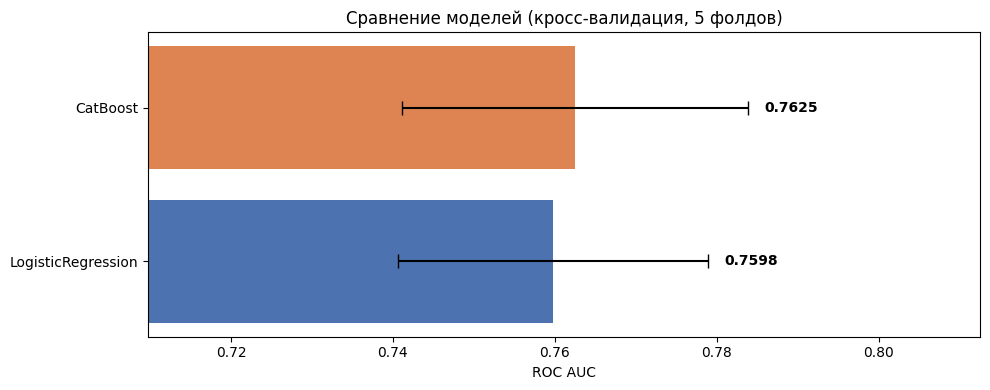

In [67]:
# Строим график сравнения моделей
model_names = list(results.keys())
means = [results[n]['mean_auc'] for n in model_names]
stds = [results[n]['std_auc'] for n in model_names]

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.barh(model_names, means, xerr=stds,
               color=['#4C72B0', '#DD8452'], capsize=5)
ax.set_xlabel('ROC AUC')
ax.set_title('Сравнение моделей (кросс-валидация, 5 фолдов)')
for i, (m, s) in enumerate(zip(means, stds)):
    ax.text(m + s + 0.002, i, f'{m:.4f}', va='center', fontweight='bold')
ax.set_xlim(min(means) - 0.05, max(means) + 0.05)
plt.tight_layout()
plt.show()

## Подбор гиперпараметров

Подбор гиперпараметров будем выполнять с помощью RandomizedSearchCV.

In [68]:
# Подбор гиперпараметров RandomizedSearchCV
if best_model_name == 'CatBoost':
    print('Подбор гиперпараметров для CatBoost...')

    param_distributions = {
        'iterations': [300, 500, 700],
        'depth': [4, 5],
        'learning_rate': [0.03, 0.05],
        'l2_leaf_reg': [3, 5],
        #'border_count': [32, 64, 128],
        #'bagging_temperature': [0, 0.5, 1],
        'scale_pos_weight': [1, 5]  # подбор веса класса 1
    }

    search = RandomizedSearchCV(
        CatBoostClassifier(
            random_seed=RANDOM_STATE, verbose=0, thread_count=-1
        ),
        param_distributions,
        n_iter=20,
        cv=cv,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        n_jobs=1,
        verbose=2
    )
    search.fit(X_train, y_train)

else:  # LogisticRegression
    print('Подбор гиперпараметров для LogisticRegression...')

    param_distributions = {
        'C': np.logspace(-3, 3, 15),
        'penalty': ['l1', 'l2'],
        'solver': ['saga'],
    }

    search = RandomizedSearchCV(
        LogisticRegression(max_iter=2000, random_state=RANDOM_STATE,
                           class_weight='balanced'),
        param_distributions,
        n_iter=20,
        cv=cv,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_train_scaled, y_train)

best_params = search.best_params_
best_cv_score = search.best_score_

print(f'\nЛучший ROC AUC на CV: {best_cv_score:.4f}')
print(f'Лучшие параметры: {best_params}')

Подбор гиперпараметров для CatBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END depth=5, iterations=300, l2_leaf_reg=3, learning_rate=0.05, scale_pos_weight=5; total time=   6.2s
[CV] END depth=5, iterations=300, l2_leaf_reg=3, learning_rate=0.05, scale_pos_weight=5; total time=   4.6s
[CV] END depth=5, iterations=300, l2_leaf_reg=3, learning_rate=0.05, scale_pos_weight=5; total time=   6.1s
[CV] END depth=5, iterations=300, l2_leaf_reg=3, learning_rate=0.05, scale_pos_weight=5; total time=   4.5s
[CV] END depth=5, iterations=300, l2_leaf_reg=3, learning_rate=0.05, scale_pos_weight=5; total time=   4.6s
[CV] END depth=5, iterations=700, l2_leaf_reg=3, learning_rate=0.03, scale_pos_weight=1; total time=  11.8s
[CV] END depth=5, iterations=700, l2_leaf_reg=3, learning_rate=0.03, scale_pos_weight=1; total time=  11.9s
[CV] END depth=5, iterations=700, l2_leaf_reg=3, learning_rate=0.03, scale_pos_weight=1; total time=  12.0s
[CV] END depth=5, iterations=700, l

## Этап 6: Финальное тестирование

Протестируем модель на тестовых данных.

In [69]:
# Обучение финальной модели с лучшими гиперпараметрами
if best_model_name == 'CatBoost':
    final_model = CatBoostClassifier(
        **best_params,
        random_seed=RANDOM_STATE,
        verbose=0,
        thread_count=-1
    )
    final_model.fit(X_train, y_train)
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]
    y_pred = final_model.predict(X_test)

else:  # LogisticRegression
    final_model = LogisticRegression(
        **best_params,
        max_iter=2000,
        random_state=RANDOM_STATE,
        class_weight='balanced'
    )
    final_model.fit(X_train_scaled, y_train)
    X_test_scaled = scaler.transform(X_test)
    y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]
    y_pred = final_model.predict(X_test_scaled)

# Оценка на тестовой выборке
test_auc = roc_auc_score(y_test, y_pred_proba)
print(f'=== ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ===')
print(f'Модель: {best_model_name}')
print(f'ROC AUC на тесте: {test_auc:.4f}')
print(f'\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['Нет покупки', 'Покупка']))

=== ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ ===
Модель: CatBoost
ROC AUC на тесте: 0.7830

Classification Report:
              precision    recall  f1-score   support

 Нет покупки       0.98      1.00      0.99      9778
     Покупка       0.26      0.04      0.07       192

    accuracy                           0.98      9970
   macro avg       0.62      0.52      0.53      9970
weighted avg       0.97      0.98      0.97      9970



Метрика ROC-AUC получилась выше, чем требование заказчика. Но при таком дибалансе классов, она мало полезна. Модель очень плохо определяет класс 1. При сильном дисбалансе порог 0.5 неоптимален для класса 1.Попробуем настроить порог классификации. Подбирать порог будем исходя из максимизации F1-score для класса 1.

Оптимальный порог по F1: 0.2066
F1 при оптимальном пороге: 0.1793
Precision: 0.1213, Recall: 0.3438

Classification Report (порог = 0.2066):
              precision    recall  f1-score   support

 Нет покупки       0.99      0.95      0.97      9778
     Покупка       0.12      0.34      0.18       192

    accuracy                           0.94      9970
   macro avg       0.55      0.65      0.57      9970
weighted avg       0.97      0.94      0.95      9970



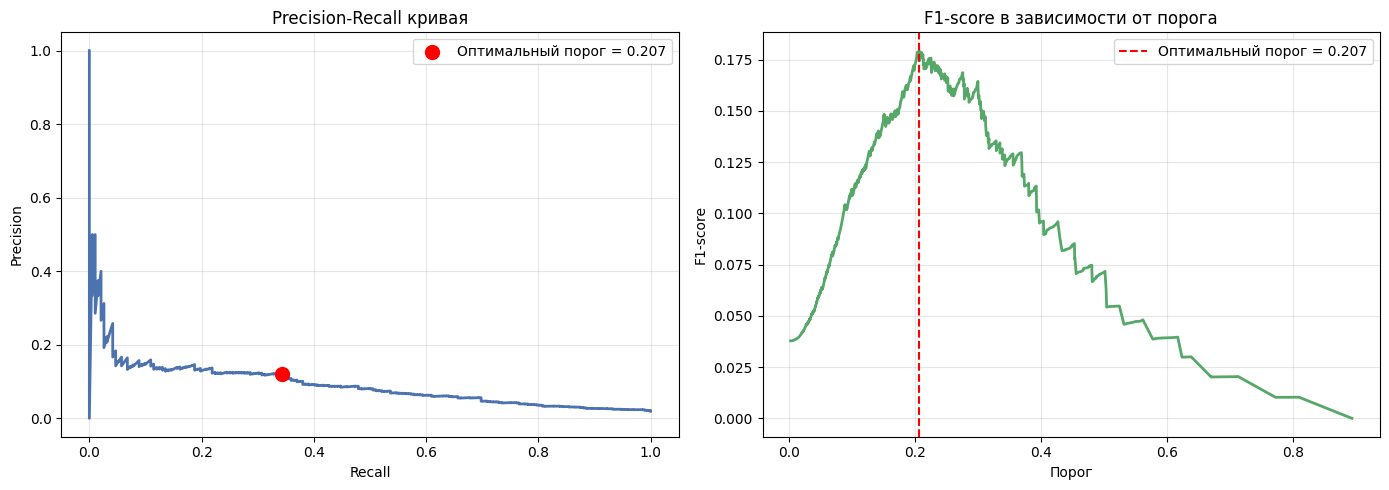

In [70]:
# Подбираем порог, максимизирующий F1-score для класса 1
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

# F1 для каждого порога
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_threshold_idx]

print(f'Оптимальный порог по F1: {best_threshold:.4f}')
print(f'F1 при оптимальном пороге: {f1_scores[best_threshold_idx]:.4f}')
print(f'Precision: {precisions[best_threshold_idx]:.4f}, Recall: {recalls[best_threshold_idx]:.4f}')

# Предсказания с оптимальным порогом
y_pred_opt = (y_pred_proba >= best_threshold).astype(int)

print(f'\nClassification Report (порог = {best_threshold:.4f}):')
print(classification_report(y_test, y_pred_opt, target_names=['Нет покупки', 'Покупка']))

# Визуализация Precision-Recall кривой
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(recalls, precisions, color='#4C72B0', lw=2)
axes[0].scatter(recalls[best_threshold_idx], precisions[best_threshold_idx],
                color='red', s=100, zorder=5, label=f'Оптимальный порог = {best_threshold:.3f}')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall кривая')
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1 в зависимости от порога
axes[1].plot(thresholds_pr, f1_scores[:-1], color='#55A868', lw=2)
axes[1].axvline(x=best_threshold, color='red', linestyle='--', label=f'Оптимальный порог = {best_threshold:.3f}')
axes[1].set_xlabel('Порог')
axes[1].set_ylabel('F1-score')
axes[1].set_title('F1-score в зависимости от порога')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Построим матрицу ошибок с настроенным порогом классификации.

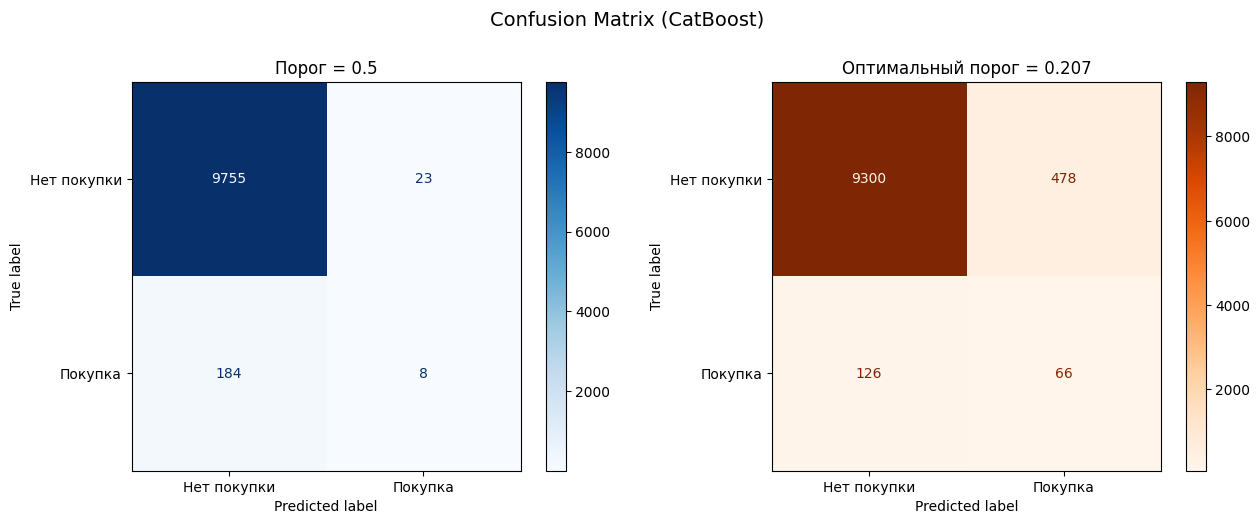

In [71]:
# Строим Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Матрица с порогом 0.5
cm_default = confusion_matrix(y_test, y_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_default, display_labels=['Нет покупки', 'Покупка'])
disp1.plot(cmap='Blues', ax=axes[0])
axes[0].set_title(f'Порог = 0.5')

# Матрица с оптимальным порогом
cm_opt = confusion_matrix(y_test, y_pred_opt)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=['Нет покупки', 'Покупка'])
disp2.plot(cmap='Oranges', ax=axes[1])
axes[1].set_title(f'Оптимальный порог = {best_threshold:.3f}')

plt.suptitle(f'Confusion Matrix ({best_model_name})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

При уменьшении порога клссификации модель стала чаще правильно определять класс 1, но и чаще стала ошибаться.

Построим график ROC-кривой.

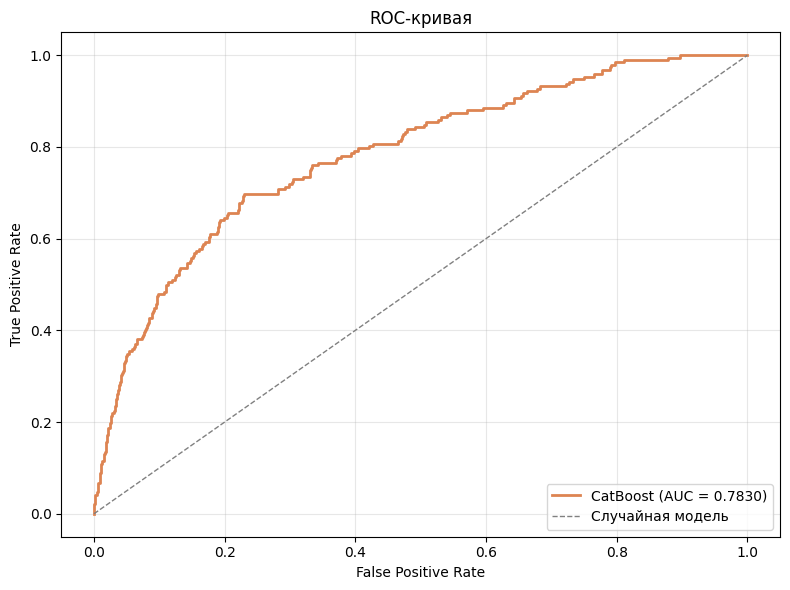

In [72]:
# ROC-кривая
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='#DD8452', lw=2, label=f'{best_model_name} (AUC = {test_auc:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Случайная модель')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC-кривая')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Несмотря на невысокую точность модель лучше предсказывает, чем случайная модель.

Посмотрим наиболее важные признаки модели.

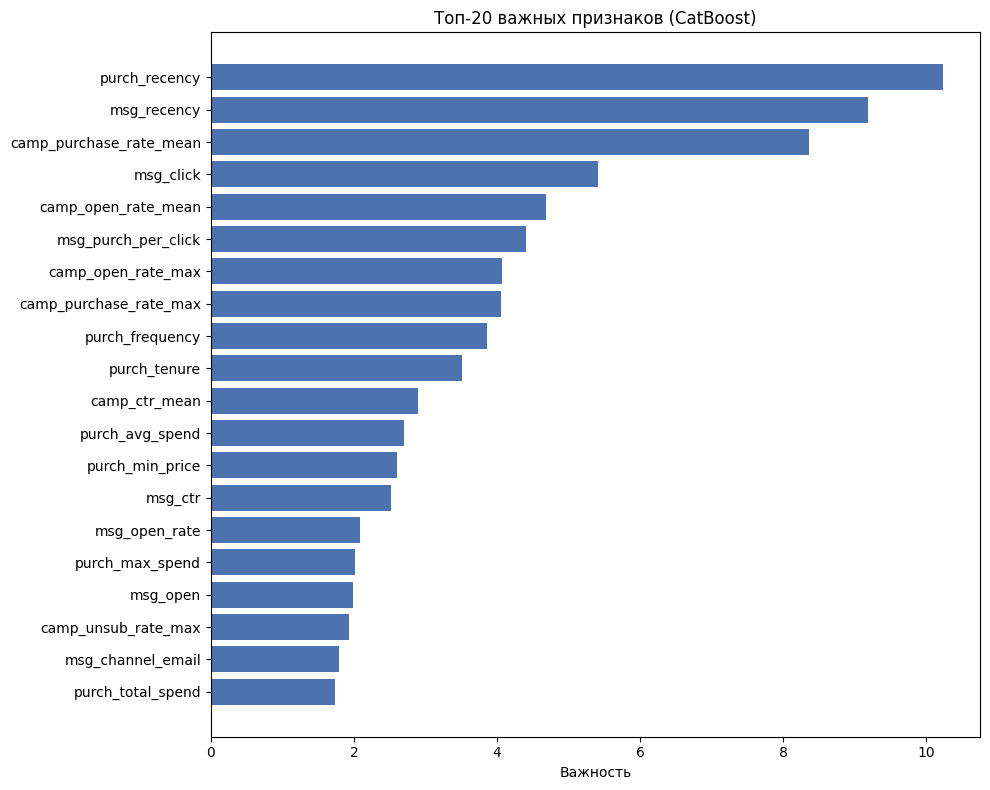


Топ-20 признаков:
  purch_recency                           : 10.2406
  msg_recency                             : 9.1921
  camp_purchase_rate_mean                 : 8.3616
  msg_click                               : 5.4140
  camp_open_rate_mean                     : 4.6892
  msg_purch_per_click                     : 4.4119
  camp_open_rate_max                      : 4.0667
  camp_purchase_rate_max                  : 4.0577
  purch_frequency                         : 3.8570
  purch_tenure                            : 3.5144
  camp_ctr_mean                           : 2.9006
  purch_avg_spend                         : 2.7017
  purch_min_price                         : 2.6080
  msg_ctr                                 : 2.5166
  msg_open_rate                           : 2.0830
  purch_max_spend                         : 2.0128
  msg_open                                : 1.9933
  camp_unsub_rate_max                     : 1.9303
  msg_channel_email                       : 1.7976
  purch_tot

In [73]:
# Feature Importance: топ-20 признаков

if hasattr(final_model, 'feature_importances_'):
    importances = final_model.feature_importances_
elif hasattr(final_model, 'coef_'):
    importances = np.abs(final_model.coef_[0])
else:
    importances = None

if importances is not None:
    feat_imp = pd.DataFrame({
        'Признак': feature_cols,
        'Важность': importances
    }).sort_values('Важность', ascending=False)

    top20 = feat_imp.head(20)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.barh(range(len(top20)), top20['Важность'].values, color='#4C72B0')
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20['Признак'].values)
    ax.invert_yaxis()
    ax.set_title(f'Топ-20 важных признаков ({best_model_name})')
    ax.set_xlabel('Важность')
    plt.tight_layout()
    plt.show()

    print('\nТоп-20 признаков:')
    for _, row in top20.iterrows():
        print(f'  {row["Признак"]:40s}: {row["Важность"]:.4f}')
else:
    print('Feature importance недоступен для данной модели.')

Наиболее важными признаками является: давность последней покупки и давность последнего сообщения.

## Выводы

1. **Данные**: проведён полный EDA всех 5 датасетов, выявлены особенности распределений, пропуски и дубликаты.

2. **Признаки**: создано множество признаков из трёх источников:
   - **Покупки**: количество, суммы, средний чек, давность, частота, категории.
   - **Рассылки**: события по типам, конверсии (CTR, purchase rate), каналы, жалобы/отписки.
   - **Кампании**: агрегированные характеристики кампаний (open rate, CTR, purchase rate) — присоединены к клиентам.

3. **Модели**: сравнены LogisticRegression и CatBoost по ROC AUC на кросс-валидации.

4. **Гиперпараметры**: для лучшей модели проведён подбор через RandomizedSearchCV.

5. **Результат**: финальная модель протестирована на тестовой выборке. Построены ROC-кривая, confusion matrix, выведены топ-20 важных признаков.